In [24]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import cv2


class handDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        # self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
#         img = Image.open(img_path).convert("RGB")
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        masks = []
        for i in range(1,5):
            mask_path = os.path.join(self.root, "masks", str(i), self.imgs[idx])
            if os.path.isfile(mask_path):
                mask_tmp = np.array(Image.open(mask_path))
                masks.append(mask_tmp > 0)
        assert len(masks) > 0, print(self.imgs[idx] + " has no mask")

        masks= np.array(masks)
        # mask = np.array(mask)
        # # instances are encoded as different colors
        # obj_ids = np.unique(mask)
        # # first id is the background, so remove it
        # obj_ids = obj_ids[1:]
        # # split the color-encoded mask into a set
        # # of binary masks
        # masks = mask == obj_ids[:, None, None]
        # # get bounding box coordinates for each mask
        num_objs = masks.shape[0]
        boxes = []
        areas = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = int(np.min(pos[1]))
            xmax = int(np.max(pos[1]))
            ymin = int(np.min(pos[0]))
            ymax = int(np.max(pos[0]))
            assert xmax > xmin and ymax > ymin, print("empty rectangle for " + self.imgs[idx])
            areas.append((xmax - xmin)*(ymax - ymin))
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.int32)
        areas = torch.as_tensor(areas, dtype=torch.int32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
#         area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = areas
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)




In [25]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [9]:
from matplotlib.pyplot import imshow
dataset = handDataset('LI/')
dataset[0]
# for i in range(13,25):
#     print(i)
#     img, data = dataset[i]
#     pix = np.array(img)
#     mask = data['masks'].cpu().numpy()
#     boxes = data['boxes'].cpu().numpy()
#     print(boxes.shape)
#     print(mask.shape)
#     # pix= pix.reshape((pix.shape[2], pix.shape[1], pix.shape[0]))
#     print(pix.shape)
#     # for j in range(boxes.shape[0]):
#     #     cv2.rectangle(pix, (boxes[j][0], boxes[j][3]), (boxes[j][2], boxes[j][1]), (255, 255, 0), 1)
#     masks = (mask[0] != 0)
#     for j in range(1, mask.shape[0]):
#         masks = masks | (mask[j] != 0)
#     print(masks.shape)
#     pix[(masks != 0)] = 255
#     imshow(pix)


(array([[[108, 125, 119],
         [ 63,  80,  74],
         [  6,  21,  16],
         ...,
         [ 85,  86,  78],
         [ 83,  84,  76],
         [ 82,  83,  75]],
 
        [[109, 126, 120],
         [ 67,  84,  78],
         [ 10,  25,  20],
         ...,
         [ 85,  86,  78],
         [ 83,  84,  76],
         [ 82,  83,  75]],
 
        [[109, 126, 120],
         [ 74,  91,  85],
         [ 17,  32,  27],
         ...,
         [ 85,  86,  78],
         [ 83,  84,  76],
         [ 82,  83,  75]],
 
        ...,
 
        [[ 21,  21,  21],
         [ 21,  21,  21],
         [ 21,  21,  21],
         ...,
         [ 28,  28,  30],
         [ 28,  28,  30],
         [ 28,  28,  30]],
 
        [[ 21,  21,  21],
         [ 21,  21,  21],
         [ 21,  21,  21],
         ...,
         [ 28,  28,  30],
         [ 28,  28,  30],
         [ 28,  28,  30]],
 
        [[ 21,  21,  21],
         [ 21,  21,  21],
         [ 21,  21,  21],
         ...,
         [ 28,  28,  30],
  

In [10]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [11]:
# use our dataset and defined transformations
dataset = handDataset('./', get_transform(train=True))
dataset_test = handDataset('./', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-800])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-800:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=16,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=False, num_workers=16,
    collate_fn=utils.collate_fn)

In [12]:
dataset[0]

(tensor([[[0.7137, 0.7137, 0.7137,  ..., 0.5529, 0.5529, 0.5490],
          [0.7137, 0.7137, 0.7137,  ..., 0.5569, 0.5569, 0.5569],
          [0.7176, 0.7176, 0.7176,  ..., 0.5569, 0.5569, 0.5569],
          ...,
          [0.3333, 0.3333, 0.3373,  ..., 0.2314, 0.2431, 0.2510],
          [0.3333, 0.3333, 0.3373,  ..., 0.2314, 0.2431, 0.2510],
          [0.3333, 0.3333, 0.3412,  ..., 0.2314, 0.2431, 0.2510]],
 
         [[0.7373, 0.7373, 0.7373,  ..., 0.7373, 0.7373, 0.7333],
          [0.7373, 0.7373, 0.7373,  ..., 0.7373, 0.7373, 0.7373],
          [0.7412, 0.7412, 0.7412,  ..., 0.7373, 0.7373, 0.7373],
          ...,
          [0.3529, 0.3529, 0.3569,  ..., 0.2353, 0.2471, 0.2549],
          [0.3529, 0.3529, 0.3569,  ..., 0.2353, 0.2471, 0.2549],
          [0.3529, 0.3529, 0.3608,  ..., 0.2353, 0.2471, 0.2549]],
 
         [[0.7216, 0.7216, 0.7216,  ..., 0.6980, 0.6980, 0.6941],
          [0.7216, 0.7216, 0.7216,  ..., 0.6980, 0.6980, 0.6980],
          [0.7255, 0.7255, 0.7255,  ...,

In [13]:
device = torch.device('cuda')
# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=8,
                                               gamma=0.1)

In [18]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'weights/model_best.tar')

In [17]:
  start_epoch = 0
  resume = 'live_client/exp_2/best_checkpoint.tar'
  checkpoint = torch.load(resume)
  start_epoch = checkpoint['epoch']
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  print("=> loaded checkpoint '{}' (epoch {})" .format(resume, checkpoint['epoch']))

=> loaded checkpoint 'live_client/exp_2/best_checkpoint.tar' (epoch 9)


In [16]:
start_epoch = 0

In [18]:
start_epoch

9

In [9]:
res = evaluate(model, data_loader_test, device=device)

creating index...
index created!
Test:  [0/5]  eta: 0:00:09  model_time: 1.5840 (1.5840)  evaluator_time: 0.0700 (0.0700)  time: 1.9401  data: 0.2510  max mem: 2357
Test:  [4/5]  eta: 0:00:00  model_time: 0.3570 (0.6009)  evaluator_time: 0.0590 (0.0606)  time: 0.9291  data: 0.2503  max mem: 2358
Test: Total time: 0:00:04 (0.9299 s / it)
Averaged stats: model_time: 0.3570 (0.6009)  evaluator_time: 0.0590 (0.0606)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.999
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.915
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.629
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDet

In [32]:
res.coco_eval['segm'].params.iouType

'segm'

In [28]:
res.coco_eval['segm'].stats 

array([ 0.72885384,  0.99434078,  0.91681999, -1.        ,  0.52710985,
        0.74587011,  0.24477612,  0.75671642,  0.75671642, -1.        ,
        0.6       ,  0.775     ])

In [33]:
res.coco_eval['segm'].stats[0]

0.728853843376946

In [28]:
# let's train it for 10 epochs
num_epochs = 32
bestIOU = 0.5
for epoch in range(start_epoch, num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    res = evaluate(model, data_loader_test, device=device)
    iou50to95 = res.coco_eval['segm'].stats[0]
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict(),},
        False, 
        filename='weights/checkpoint_' + str(epoch+1) + '.tar')
    if(bestIOU < iou50to95):
        print("best IOU: " + str(iou50to95) + "\n\n\n")
        print("at epoch: " + str(epoch) + "\n\n\n")
        bestIOU = iou50to95
        save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict(),},
        False, 
        filename='weights/best_checkpoint.tar')
        

Epoch: [0]  [  0/997]  eta: 0:32:49  lr: 0.000020  loss: 3.5232 (3.5232)  loss_classifier: 0.5690 (0.5690)  loss_box_reg: 0.2526 (0.2526)  loss_mask: 2.6314 (2.6314)  loss_objectness: 0.0474 (0.0474)  loss_rpn_box_reg: 0.0228 (0.0228)  time: 1.9750  data: 1.1735  max mem: 6048
Epoch: [0]  [100/997]  eta: 0:11:41  lr: 0.001023  loss: 0.5292 (1.0112)  loss_classifier: 0.1103 (0.2269)  loss_box_reg: 0.1389 (0.2182)  loss_mask: 0.2367 (0.5121)  loss_objectness: 0.0110 (0.0341)  loss_rpn_box_reg: 0.0140 (0.0198)  time: 0.7787  data: 0.0087  max mem: 6048
Epoch: [0]  [200/997]  eta: 0:10:24  lr: 0.002026  loss: 0.3542 (0.7174)  loss_classifier: 0.0723 (0.1598)  loss_box_reg: 0.0630 (0.1527)  loss_mask: 0.1950 (0.3662)  loss_objectness: 0.0040 (0.0214)  loss_rpn_box_reg: 0.0128 (0.0172)  time: 0.7877  data: 0.0085  max mem: 6048
Epoch: [0]  [300/997]  eta: 0:09:06  lr: 0.003029  loss: 0.3691 (0.6051)  loss_classifier: 0.0795 (0.1337)  loss_box_reg: 0.0654 (0.1246)  loss_mask: 0.1893 (0.3140) 

Epoch: [1]  [900/997]  eta: 0:01:17  lr: 0.010000  loss: 0.2838 (0.3085)  loss_classifier: 0.0602 (0.0632)  loss_box_reg: 0.0361 (0.0477)  loss_mask: 0.1583 (0.1814)  loss_objectness: 0.0039 (0.0039)  loss_rpn_box_reg: 0.0118 (0.0124)  time: 0.7939  data: 0.0090  max mem: 6048
Epoch: [1]  [996/997]  eta: 0:00:00  lr: 0.010000  loss: 0.2979 (0.3087)  loss_classifier: 0.0585 (0.0633)  loss_box_reg: 0.0481 (0.0480)  loss_mask: 0.1661 (0.1811)  loss_objectness: 0.0035 (0.0039)  loss_rpn_box_reg: 0.0093 (0.0124)  time: 0.8171  data: 0.0084  max mem: 6048
Epoch: [1] Total time: 0:13:19 (0.8021 s / it)
creating index...
index created!
Test:  [  0/200]  eta: 0:04:26  model_time: 0.3263 (0.3263)  evaluator_time: 0.0237 (0.0237)  time: 1.3319  data: 0.9169  max mem: 6048
Test:  [100/200]  eta: 0:00:33  model_time: 0.2794 (0.2816)  evaluator_time: 0.0296 (0.0319)  time: 0.3273  data: 0.0085  max mem: 6048
Test:  [199/200]  eta: 0:00:00  model_time: 0.2805 (0.2814)  evaluator_time: 0.0306 (0.0314)

best IOU: 0.7116378738016064



at epoch: 2



Epoch: [3]  [  0/997]  eta: 0:30:51  lr: 0.010000  loss: 0.2051 (0.2051)  loss_classifier: 0.0293 (0.0293)  loss_box_reg: 0.0211 (0.0211)  loss_mask: 0.1451 (0.1451)  loss_objectness: 0.0017 (0.0017)  loss_rpn_box_reg: 0.0080 (0.0080)  time: 1.8573  data: 1.0478  max mem: 6048
Epoch: [3]  [100/997]  eta: 0:11:59  lr: 0.010000  loss: 0.2525 (0.2645)  loss_classifier: 0.0464 (0.0488)  loss_box_reg: 0.0338 (0.0353)  loss_mask: 0.1671 (0.1684)  loss_objectness: 0.0011 (0.0017)  loss_rpn_box_reg: 0.0094 (0.0104)  time: 0.7953  data: 0.0082  max mem: 6048
Epoch: [3]  [200/997]  eta: 0:10:35  lr: 0.010000  loss: 0.2526 (0.2675)  loss_classifier: 0.0434 (0.0496)  loss_box_reg: 0.0326 (0.0362)  loss_mask: 0.1591 (0.1693)  loss_objectness: 0.0010 (0.0020)  loss_rpn_box_reg: 0.0081 (0.0105)  time: 0.7960  data: 0.0083  max mem: 6048
Epoch: [3]  [300/997]  eta: 0:09:15  lr: 0.010000  loss: 0.2419 (0.2688)  loss_classifier: 0.0397 (0.0507)  loss_box_re

Epoch: [4]  [900/997]  eta: 0:01:17  lr: 0.010000  loss: 0.2538 (0.2625)  loss_classifier: 0.0447 (0.0486)  loss_box_reg: 0.0293 (0.0350)  loss_mask: 0.1569 (0.1666)  loss_objectness: 0.0010 (0.0020)  loss_rpn_box_reg: 0.0079 (0.0103)  time: 0.7926  data: 0.0083  max mem: 6048
Epoch: [4]  [996/997]  eta: 0:00:00  lr: 0.010000  loss: 0.3149 (0.2637)  loss_classifier: 0.0613 (0.0489)  loss_box_reg: 0.0463 (0.0351)  loss_mask: 0.1821 (0.1673)  loss_objectness: 0.0016 (0.0019)  loss_rpn_box_reg: 0.0112 (0.0104)  time: 0.7854  data: 0.0080  max mem: 6048
Epoch: [4] Total time: 0:13:14 (0.7971 s / it)
creating index...
index created!
Test:  [  0/200]  eta: 0:04:20  model_time: 0.4329 (0.4329)  evaluator_time: 0.0365 (0.0365)  time: 1.3036  data: 0.7827  max mem: 6048
Test:  [100/200]  eta: 0:00:33  model_time: 0.2796 (0.2823)  evaluator_time: 0.0283 (0.0315)  time: 0.3268  data: 0.0085  max mem: 6048
Test:  [199/200]  eta: 0:00:00  model_time: 0.2823 (0.2818)  evaluator_time: 0.0316 (0.0314)

Epoch: [6]  [  0/997]  eta: 0:31:43  lr: 0.010000  loss: 0.3797 (0.3797)  loss_classifier: 0.0643 (0.0643)  loss_box_reg: 0.0650 (0.0650)  loss_mask: 0.2394 (0.2394)  loss_objectness: 0.0011 (0.0011)  loss_rpn_box_reg: 0.0097 (0.0097)  time: 1.9091  data: 1.0511  max mem: 6048
Epoch: [6]  [100/997]  eta: 0:12:01  lr: 0.010000  loss: 0.2291 (0.2473)  loss_classifier: 0.0411 (0.0429)  loss_box_reg: 0.0288 (0.0308)  loss_mask: 0.1532 (0.1623)  loss_objectness: 0.0013 (0.0015)  loss_rpn_box_reg: 0.0072 (0.0099)  time: 0.7954  data: 0.0085  max mem: 6048
Epoch: [6]  [200/997]  eta: 0:10:35  lr: 0.010000  loss: 0.2360 (0.2478)  loss_classifier: 0.0357 (0.0429)  loss_box_reg: 0.0273 (0.0303)  loss_mask: 0.1669 (0.1634)  loss_objectness: 0.0008 (0.0015)  loss_rpn_box_reg: 0.0078 (0.0097)  time: 0.7934  data: 0.0082  max mem: 6048
Epoch: [6]  [300/997]  eta: 0:09:14  lr: 0.010000  loss: 0.2355 (0.2459)  loss_classifier: 0.0389 (0.0425)  loss_box_reg: 0.0263 (0.0303)  loss_mask: 0.1561 (0.1620) 

Epoch: [7]  [900/997]  eta: 0:01:17  lr: 0.010000  loss: 0.2463 (0.2515)  loss_classifier: 0.0455 (0.0450)  loss_box_reg: 0.0361 (0.0316)  loss_mask: 0.1634 (0.1631)  loss_objectness: 0.0019 (0.0018)  loss_rpn_box_reg: 0.0090 (0.0100)  time: 0.7952  data: 0.0087  max mem: 6048
Epoch: [7]  [996/997]  eta: 0:00:00  lr: 0.010000  loss: 0.2582 (0.2522)  loss_classifier: 0.0461 (0.0452)  loss_box_reg: 0.0297 (0.0317)  loss_mask: 0.1567 (0.1635)  loss_objectness: 0.0013 (0.0018)  loss_rpn_box_reg: 0.0089 (0.0101)  time: 0.7855  data: 0.0083  max mem: 6048
Epoch: [7] Total time: 0:13:13 (0.7962 s / it)
creating index...
index created!
Test:  [  0/200]  eta: 0:04:19  model_time: 0.3660 (0.3660)  evaluator_time: 0.0350 (0.0350)  time: 1.2998  data: 0.8354  max mem: 6048
Test:  [100/200]  eta: 0:00:33  model_time: 0.2796 (0.2820)  evaluator_time: 0.0289 (0.0313)  time: 0.3268  data: 0.0086  max mem: 6048
Test:  [199/200]  eta: 0:00:00  model_time: 0.2823 (0.2818)  evaluator_time: 0.0329 (0.0311)

best IOU: 0.7275120575696004



at epoch: 8



Epoch: [9]  [  0/997]  eta: 0:28:18  lr: 0.001000  loss: 0.1743 (0.1743)  loss_classifier: 0.0245 (0.0245)  loss_box_reg: 0.0156 (0.0156)  loss_mask: 0.1283 (0.1283)  loss_objectness: 0.0010 (0.0010)  loss_rpn_box_reg: 0.0050 (0.0050)  time: 1.7040  data: 0.8502  max mem: 6048
Epoch: [9]  [100/997]  eta: 0:11:59  lr: 0.001000  loss: 0.2274 (0.2134)  loss_classifier: 0.0323 (0.0330)  loss_box_reg: 0.0202 (0.0222)  loss_mask: 0.1601 (0.1498)  loss_objectness: 0.0006 (0.0011)  loss_rpn_box_reg: 0.0058 (0.0074)  time: 0.7962  data: 0.0083  max mem: 6048
Epoch: [9]  [200/997]  eta: 0:10:37  lr: 0.001000  loss: 0.2059 (0.2165)  loss_classifier: 0.0318 (0.0339)  loss_box_reg: 0.0210 (0.0226)  loss_mask: 0.1490 (0.1517)  loss_objectness: 0.0005 (0.0010)  loss_rpn_box_reg: 0.0065 (0.0073)  time: 0.7995  data: 0.0085  max mem: 6067
Epoch: [9]  [300/997]  eta: 0:09:17  lr: 0.001000  loss: 0.1923 (0.2154)  loss_classifier: 0.0321 (0.0339)  loss_box_re

Epoch: [10]  [900/997]  eta: 0:01:17  lr: 0.001000  loss: 0.2174 (0.2105)  loss_classifier: 0.0303 (0.0325)  loss_box_reg: 0.0218 (0.0206)  loss_mask: 0.1502 (0.1495)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0064 (0.0071)  time: 0.7982  data: 0.0083  max mem: 6067
Epoch: [10]  [996/997]  eta: 0:00:00  lr: 0.001000  loss: 0.2182 (0.2111)  loss_classifier: 0.0296 (0.0326)  loss_box_reg: 0.0200 (0.0207)  loss_mask: 0.1566 (0.1498)  loss_objectness: 0.0007 (0.0008)  loss_rpn_box_reg: 0.0059 (0.0071)  time: 0.7844  data: 0.0086  max mem: 6067
Epoch: [10] Total time: 0:13:15 (0.7982 s / it)
creating index...
index created!
Test:  [  0/200]  eta: 0:04:23  model_time: 0.3927 (0.3927)  evaluator_time: 0.0333 (0.0333)  time: 1.3185  data: 0.8473  max mem: 6067
Test:  [100/200]  eta: 0:00:33  model_time: 0.2786 (0.2807)  evaluator_time: 0.0252 (0.0272)  time: 0.3206  data: 0.0083  max mem: 6067
Test:  [199/200]  eta: 0:00:00  model_time: 0.2793 (0.2799)  evaluator_time: 0.0291 (0.02

best IOU: 0.7326486743351586



at epoch: 11



Epoch: [12]  [  0/997]  eta: 0:29:19  lr: 0.001000  loss: 0.2658 (0.2658)  loss_classifier: 0.0408 (0.0408)  loss_box_reg: 0.0289 (0.0289)  loss_mask: 0.1704 (0.1704)  loss_objectness: 0.0039 (0.0039)  loss_rpn_box_reg: 0.0218 (0.0218)  time: 1.7651  data: 0.9018  max mem: 6067
Epoch: [12]  [100/997]  eta: 0:11:58  lr: 0.001000  loss: 0.1976 (0.2033)  loss_classifier: 0.0287 (0.0307)  loss_box_reg: 0.0171 (0.0181)  loss_mask: 0.1399 (0.1471)  loss_objectness: 0.0003 (0.0006)  loss_rpn_box_reg: 0.0057 (0.0068)  time: 0.7910  data: 0.0086  max mem: 6067
Epoch: [12]  [200/997]  eta: 0:10:36  lr: 0.001000  loss: 0.2015 (0.2051)  loss_classifier: 0.0295 (0.0308)  loss_box_reg: 0.0190 (0.0189)  loss_mask: 0.1458 (0.1480)  loss_objectness: 0.0003 (0.0006)  loss_rpn_box_reg: 0.0063 (0.0068)  time: 0.7987  data: 0.0086  max mem: 6067
Epoch: [12]  [300/997]  eta: 0:09:16  lr: 0.001000  loss: 0.2001 (0.2048)  loss_classifier: 0.0277 (0.0309)  loss_b

Epoch: [13]  [900/997]  eta: 0:01:17  lr: 0.001000  loss: 0.1925 (0.2044)  loss_classifier: 0.0284 (0.0309)  loss_box_reg: 0.0179 (0.0189)  loss_mask: 0.1402 (0.1470)  loss_objectness: 0.0002 (0.0007)  loss_rpn_box_reg: 0.0051 (0.0069)  time: 0.7944  data: 0.0085  max mem: 6067
Epoch: [13]  [996/997]  eta: 0:00:00  lr: 0.001000  loss: 0.1955 (0.2048)  loss_classifier: 0.0289 (0.0310)  loss_box_reg: 0.0160 (0.0190)  loss_mask: 0.1445 (0.1471)  loss_objectness: 0.0002 (0.0007)  loss_rpn_box_reg: 0.0056 (0.0069)  time: 0.7839  data: 0.0086  max mem: 6067
Epoch: [13] Total time: 0:13:15 (0.7978 s / it)
creating index...
index created!
Test:  [  0/200]  eta: 0:04:25  model_time: 0.3552 (0.3552)  evaluator_time: 0.0270 (0.0270)  time: 1.3261  data: 0.8701  max mem: 6067
Test:  [100/200]  eta: 0:00:33  model_time: 0.2788 (0.2797)  evaluator_time: 0.0250 (0.0263)  time: 0.3198  data: 0.0084  max mem: 6067
Test:  [199/200]  eta: 0:00:00  model_time: 0.2784 (0.2792)  evaluator_time: 0.0257 (0.02

Epoch: [15]  [  0/997]  eta: 0:30:41  lr: 0.001000  loss: 0.1563 (0.1563)  loss_classifier: 0.0198 (0.0198)  loss_box_reg: 0.0164 (0.0164)  loss_mask: 0.1159 (0.1159)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0039 (0.0039)  time: 1.8473  data: 1.0010  max mem: 6067
Epoch: [15]  [100/997]  eta: 0:11:59  lr: 0.001000  loss: 0.1896 (0.1943)  loss_classifier: 0.0277 (0.0284)  loss_box_reg: 0.0154 (0.0170)  loss_mask: 0.1432 (0.1423)  loss_objectness: 0.0003 (0.0006)  loss_rpn_box_reg: 0.0062 (0.0061)  time: 0.7874  data: 0.0081  max mem: 6067
Epoch: [15]  [200/997]  eta: 0:10:36  lr: 0.001000  loss: 0.2064 (0.1997)  loss_classifier: 0.0266 (0.0295)  loss_box_reg: 0.0172 (0.0177)  loss_mask: 0.1469 (0.1456)  loss_objectness: 0.0003 (0.0005)  loss_rpn_box_reg: 0.0059 (0.0063)  time: 0.7987  data: 0.0083  max mem: 6067
Epoch: [15]  [300/997]  eta: 0:09:16  lr: 0.001000  loss: 0.2019 (0.1997)  loss_classifier: 0.0275 (0.0298)  loss_box_reg: 0.0161 (0.0177)  loss_mask: 0.1399 (0.14

Epoch: [16]  [900/997]  eta: 0:01:17  lr: 0.000100  loss: 0.1926 (0.1969)  loss_classifier: 0.0301 (0.0289)  loss_box_reg: 0.0165 (0.0171)  loss_mask: 0.1378 (0.1439)  loss_objectness: 0.0004 (0.0006)  loss_rpn_box_reg: 0.0057 (0.0064)  time: 0.8020  data: 0.0084  max mem: 6070
Epoch: [16]  [996/997]  eta: 0:00:00  lr: 0.000100  loss: 0.1875 (0.1971)  loss_classifier: 0.0275 (0.0290)  loss_box_reg: 0.0147 (0.0171)  loss_mask: 0.1420 (0.1439)  loss_objectness: 0.0001 (0.0006)  loss_rpn_box_reg: 0.0056 (0.0064)  time: 0.7848  data: 0.0088  max mem: 6070
Epoch: [16] Total time: 0:13:15 (0.7977 s / it)
creating index...
index created!
Test:  [  0/200]  eta: 0:04:20  model_time: 0.4313 (0.4313)  evaluator_time: 0.0399 (0.0399)  time: 1.3030  data: 0.7802  max mem: 6070
Test:  [100/200]  eta: 0:00:33  model_time: 0.2783 (0.2804)  evaluator_time: 0.0252 (0.0265)  time: 0.3202  data: 0.0085  max mem: 6070
Test:  [199/200]  eta: 0:00:00  model_time: 0.2787 (0.2796)  evaluator_time: 0.0267 (0.02

 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.260
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.767
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.767
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.250
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.562
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.785
Epoch: [18]  [  0/997]  eta: 0:29:15  lr: 0.000100  loss: 0.2154 (0.2154)  loss_classifier: 0.0347 (0.0347)  loss_box_reg: 0.0139 (0.0139)  loss_mask: 0.1451 (0.1451)  loss_objectness: 0.0026 (0.0026)  loss_rpn_box_reg: 0.0192 (0.0192)  time: 1.7603  data: 0.9194  max mem: 6070
Epoch: [18]  [100/997]  eta: 0:12:01  lr: 0.000100  loss: 0.1857 (0.1984)  loss_classifier: 0.0239 (0.0295)  loss_box_reg: 0.0146 (0.0176)  loss_mask: 0.1488 (0.1441)  loss_objectness: 0.0004 (0.0007)  loss_rpn_box_reg: 0.0050 (0.0065)  time

Epoch: [19]  [800/997]  eta: 0:02:37  lr: 0.000100  loss: 0.1862 (0.1963)  loss_classifier: 0.0246 (0.0288)  loss_box_reg: 0.0155 (0.0171)  loss_mask: 0.1406 (0.1434)  loss_objectness: 0.0002 (0.0006)  loss_rpn_box_reg: 0.0055 (0.0064)  time: 0.7941  data: 0.0081  max mem: 6070
Epoch: [19]  [900/997]  eta: 0:01:17  lr: 0.000100  loss: 0.1939 (0.1965)  loss_classifier: 0.0278 (0.0288)  loss_box_reg: 0.0154 (0.0170)  loss_mask: 0.1375 (0.1437)  loss_objectness: 0.0003 (0.0006)  loss_rpn_box_reg: 0.0048 (0.0064)  time: 0.7996  data: 0.0083  max mem: 6070
Epoch: [19]  [996/997]  eta: 0:00:00  lr: 0.000100  loss: 0.1832 (0.1958)  loss_classifier: 0.0243 (0.0286)  loss_box_reg: 0.0136 (0.0169)  loss_mask: 0.1383 (0.1433)  loss_objectness: 0.0002 (0.0006)  loss_rpn_box_reg: 0.0059 (0.0064)  time: 0.7818  data: 0.0079  max mem: 6070
Epoch: [19] Total time: 0:13:15 (0.7982 s / it)
creating index...
index created!
Test:  [  0/200]  eta: 0:04:27  model_time: 0.3337 (0.3337)  evaluator_time: 0.025

Epoch: [21]  [  0/997]  eta: 0:29:30  lr: 0.000100  loss: 0.1782 (0.1782)  loss_classifier: 0.0286 (0.0286)  loss_box_reg: 0.0188 (0.0188)  loss_mask: 0.1245 (0.1245)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0061 (0.0061)  time: 1.7757  data: 0.9308  max mem: 6070
Epoch: [21]  [100/997]  eta: 0:11:57  lr: 0.000100  loss: 0.1938 (0.1958)  loss_classifier: 0.0307 (0.0276)  loss_box_reg: 0.0155 (0.0161)  loss_mask: 0.1411 (0.1457)  loss_objectness: 0.0003 (0.0007)  loss_rpn_box_reg: 0.0054 (0.0057)  time: 0.7953  data: 0.0087  max mem: 6070
Epoch: [21]  [200/997]  eta: 0:10:35  lr: 0.000100  loss: 0.1929 (0.1944)  loss_classifier: 0.0269 (0.0282)  loss_box_reg: 0.0142 (0.0162)  loss_mask: 0.1423 (0.1430)  loss_objectness: 0.0002 (0.0007)  loss_rpn_box_reg: 0.0061 (0.0063)  time: 0.7981  data: 0.0085  max mem: 6070
Epoch: [21]  [300/997]  eta: 0:09:16  lr: 0.000100  loss: 0.1832 (0.1952)  loss_classifier: 0.0258 (0.0282)  loss_box_reg: 0.0145 (0.0164)  loss_mask: 0.1291 (0.14

Epoch: [22]  [900/997]  eta: 0:01:17  lr: 0.000100  loss: 0.1868 (0.1948)  loss_classifier: 0.0263 (0.0283)  loss_box_reg: 0.0151 (0.0167)  loss_mask: 0.1357 (0.1429)  loss_objectness: 0.0003 (0.0006)  loss_rpn_box_reg: 0.0059 (0.0063)  time: 0.8002  data: 0.0084  max mem: 6070
Epoch: [22]  [996/997]  eta: 0:00:00  lr: 0.000100  loss: 0.1886 (0.1948)  loss_classifier: 0.0267 (0.0283)  loss_box_reg: 0.0146 (0.0167)  loss_mask: 0.1396 (0.1428)  loss_objectness: 0.0002 (0.0006)  loss_rpn_box_reg: 0.0061 (0.0064)  time: 0.7870  data: 0.0080  max mem: 6070
Epoch: [22] Total time: 0:13:15 (0.7982 s / it)
creating index...
index created!
Test:  [  0/200]  eta: 0:04:20  model_time: 0.3636 (0.3636)  evaluator_time: 0.0273 (0.0273)  time: 1.3023  data: 0.8598  max mem: 6070
Test:  [100/200]  eta: 0:00:32  model_time: 0.2784 (0.2797)  evaluator_time: 0.0251 (0.0261)  time: 0.3199  data: 0.0086  max mem: 6070
Test:  [199/200]  eta: 0:00:00  model_time: 0.2786 (0.2793)  evaluator_time: 0.0261 (0.02

Epoch: [24]  [  0/997]  eta: 0:33:13  lr: 0.000010  loss: 0.1833 (0.1833)  loss_classifier: 0.0251 (0.0251)  loss_box_reg: 0.0164 (0.0164)  loss_mask: 0.1344 (0.1344)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0072 (0.0072)  time: 1.9996  data: 1.1880  max mem: 6070
Epoch: [24]  [100/997]  eta: 0:12:01  lr: 0.000010  loss: 0.1871 (0.1929)  loss_classifier: 0.0245 (0.0287)  loss_box_reg: 0.0157 (0.0168)  loss_mask: 0.1371 (0.1407)  loss_objectness: 0.0003 (0.0005)  loss_rpn_box_reg: 0.0057 (0.0063)  time: 0.7977  data: 0.0082  max mem: 6070
Epoch: [24]  [200/997]  eta: 0:10:37  lr: 0.000010  loss: 0.1935 (0.1949)  loss_classifier: 0.0257 (0.0286)  loss_box_reg: 0.0145 (0.0168)  loss_mask: 0.1386 (0.1426)  loss_objectness: 0.0004 (0.0005)  loss_rpn_box_reg: 0.0059 (0.0064)  time: 0.7988  data: 0.0082  max mem: 6070
Epoch: [24]  [300/997]  eta: 0:09:16  lr: 0.000010  loss: 0.1789 (0.1940)  loss_classifier: 0.0257 (0.0283)  loss_box_reg: 0.0126 (0.0165)  loss_mask: 0.1322 (0.14

Epoch: [25]  [900/997]  eta: 0:01:17  lr: 0.000010  loss: 0.1916 (0.1944)  loss_classifier: 0.0303 (0.0282)  loss_box_reg: 0.0163 (0.0165)  loss_mask: 0.1395 (0.1427)  loss_objectness: 0.0002 (0.0006)  loss_rpn_box_reg: 0.0065 (0.0064)  time: 0.7942  data: 0.0087  max mem: 6070
Epoch: [25]  [996/997]  eta: 0:00:00  lr: 0.000010  loss: 0.1785 (0.1942)  loss_classifier: 0.0232 (0.0282)  loss_box_reg: 0.0131 (0.0165)  loss_mask: 0.1308 (0.1427)  loss_objectness: 0.0002 (0.0006)  loss_rpn_box_reg: 0.0056 (0.0063)  time: 0.7871  data: 0.0085  max mem: 6070
Epoch: [25] Total time: 0:13:15 (0.7981 s / it)
creating index...
index created!
Test:  [  0/200]  eta: 0:04:23  model_time: 0.3514 (0.3514)  evaluator_time: 0.0268 (0.0268)  time: 1.3197  data: 0.8652  max mem: 6070
Test:  [100/200]  eta: 0:00:32  model_time: 0.2783 (0.2792)  evaluator_time: 0.0251 (0.0261)  time: 0.3192  data: 0.0085  max mem: 6070
Test:  [199/200]  eta: 0:00:00  model_time: 0.2787 (0.2790)  evaluator_time: 0.0261 (0.02

Epoch: [27]  [  0/997]  eta: 0:35:45  lr: 0.000010  loss: 0.1786 (0.1786)  loss_classifier: 0.0263 (0.0263)  loss_box_reg: 0.0110 (0.0110)  loss_mask: 0.1374 (0.1374)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0038 (0.0038)  time: 2.1524  data: 1.3260  max mem: 6070
Epoch: [27]  [100/997]  eta: 0:12:02  lr: 0.000010  loss: 0.2032 (0.1925)  loss_classifier: 0.0287 (0.0272)  loss_box_reg: 0.0145 (0.0158)  loss_mask: 0.1439 (0.1422)  loss_objectness: 0.0002 (0.0007)  loss_rpn_box_reg: 0.0054 (0.0065)  time: 0.7947  data: 0.0086  max mem: 6070
Epoch: [27]  [200/997]  eta: 0:10:38  lr: 0.000010  loss: 0.1867 (0.1934)  loss_classifier: 0.0311 (0.0281)  loss_box_reg: 0.0156 (0.0159)  loss_mask: 0.1367 (0.1424)  loss_objectness: 0.0002 (0.0006)  loss_rpn_box_reg: 0.0050 (0.0064)  time: 0.7941  data: 0.0083  max mem: 6070
Epoch: [27]  [300/997]  eta: 0:09:17  lr: 0.000010  loss: 0.1932 (0.1950)  loss_classifier: 0.0285 (0.0283)  loss_box_reg: 0.0159 (0.0163)  loss_mask: 0.1405 (0.14

Epoch: [28]  [900/997]  eta: 0:01:18  lr: 0.000010  loss: 0.2154 (0.1942)  loss_classifier: 0.0292 (0.0283)  loss_box_reg: 0.0171 (0.0165)  loss_mask: 0.1545 (0.1425)  loss_objectness: 0.0002 (0.0006)  loss_rpn_box_reg: 0.0055 (0.0063)  time: 0.8026  data: 0.0088  max mem: 6070
Epoch: [28]  [996/997]  eta: 0:00:00  lr: 0.000010  loss: 0.1890 (0.1946)  loss_classifier: 0.0275 (0.0284)  loss_box_reg: 0.0147 (0.0166)  loss_mask: 0.1384 (0.1426)  loss_objectness: 0.0003 (0.0006)  loss_rpn_box_reg: 0.0055 (0.0063)  time: 0.7864  data: 0.0085  max mem: 6070
Epoch: [28] Total time: 0:13:27 (0.8098 s / it)
creating index...
index created!
Test:  [  0/200]  eta: 0:04:28  model_time: 0.3106 (0.3106)  evaluator_time: 0.0261 (0.0261)  time: 1.3434  data: 0.9518  max mem: 6070
Test:  [100/200]  eta: 0:00:32  model_time: 0.2786 (0.2789)  evaluator_time: 0.0251 (0.0261)  time: 0.3198  data: 0.0087  max mem: 6070
Test:  [199/200]  eta: 0:00:00  model_time: 0.2788 (0.2788)  evaluator_time: 0.0261 (0.02

Epoch: [30]  [  0/997]  eta: 0:30:54  lr: 0.000010  loss: 0.2220 (0.2220)  loss_classifier: 0.0307 (0.0307)  loss_box_reg: 0.0201 (0.0201)  loss_mask: 0.1572 (0.1572)  loss_objectness: 0.0027 (0.0027)  loss_rpn_box_reg: 0.0114 (0.0114)  time: 1.8596  data: 1.0009  max mem: 6070
Epoch: [30]  [100/997]  eta: 0:12:00  lr: 0.000010  loss: 0.1882 (0.1895)  loss_classifier: 0.0294 (0.0282)  loss_box_reg: 0.0140 (0.0161)  loss_mask: 0.1317 (0.1380)  loss_objectness: 0.0004 (0.0007)  loss_rpn_box_reg: 0.0058 (0.0065)  time: 0.7944  data: 0.0080  max mem: 6070
Epoch: [30]  [200/997]  eta: 0:10:37  lr: 0.000010  loss: 0.1993 (0.1934)  loss_classifier: 0.0274 (0.0286)  loss_box_reg: 0.0170 (0.0165)  loss_mask: 0.1456 (0.1413)  loss_objectness: 0.0003 (0.0007)  loss_rpn_box_reg: 0.0057 (0.0064)  time: 0.7982  data: 0.0083  max mem: 6070
Epoch: [30]  [300/997]  eta: 0:09:16  lr: 0.000010  loss: 0.1910 (0.1947)  loss_classifier: 0.0282 (0.0286)  loss_box_reg: 0.0152 (0.0167)  loss_mask: 0.1432 (0.14

Epoch: [31]  [900/997]  eta: 0:01:20  lr: 0.000010  loss: 0.1942 (0.1941)  loss_classifier: 0.0284 (0.0282)  loss_box_reg: 0.0140 (0.0165)  loss_mask: 0.1460 (0.1425)  loss_objectness: 0.0002 (0.0006)  loss_rpn_box_reg: 0.0051 (0.0063)  time: 0.8373  data: 0.0088  max mem: 6070
Epoch: [31]  [996/997]  eta: 0:00:00  lr: 0.000010  loss: 0.1840 (0.1940)  loss_classifier: 0.0243 (0.0282)  loss_box_reg: 0.0145 (0.0165)  loss_mask: 0.1377 (0.1425)  loss_objectness: 0.0002 (0.0006)  loss_rpn_box_reg: 0.0053 (0.0063)  time: 0.8214  data: 0.0087  max mem: 6070
Epoch: [31] Total time: 0:13:48 (0.8315 s / it)
creating index...
index created!
Test:  [  0/200]  eta: 0:04:26  model_time: 0.4026 (0.4026)  evaluator_time: 0.0337 (0.0337)  time: 1.3335  data: 0.8228  max mem: 6070
Test:  [100/200]  eta: 0:00:34  model_time: 0.2890 (0.2970)  evaluator_time: 0.0253 (0.0269)  time: 0.3350  data: 0.0088  max mem: 6070
Test:  [199/200]  eta: 0:00:00  model_time: 0.2920 (0.2972)  evaluator_time: 0.0262 (0.02

In [0]:
exit here

In [9]:
# pick one image from the test set
img, _ = dataset_test[1]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [0]:
  start_epoch = 0
  resume = 'weights/checkpoint_best.tar'
  checkpoint = torch.load(resume)
  start_epoch = checkpoint['epoch']
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  print("=> loaded checkpoint '{}' (epoch {})" .format(resume, checkpoint['epoch']))

In [23]:
img, _ = dataset_test[0]
img[0]

tensor([[0.0353, 0.0431, 0.0431,  ..., 0.0196, 0.0157, 0.0196],
        [0.0353, 0.0392, 0.0392,  ..., 0.0196, 0.0196, 0.0196],
        [0.0392, 0.0431, 0.0471,  ..., 0.0196, 0.0196, 0.0196],
        ...,
        [0.5216, 0.5216, 0.5216,  ..., 0.5255, 0.5255, 0.5255],
        [0.5216, 0.5216, 0.5216,  ..., 0.5333, 0.5294, 0.5294],
        [0.5216, 0.5216, 0.5216,  ..., 0.5333, 0.5333, 0.5333]])

40
(4, 4)
(4, 720, 1280)
(720, 1280, 3)
[0. 0. 0. 0.]
(720, 1280)


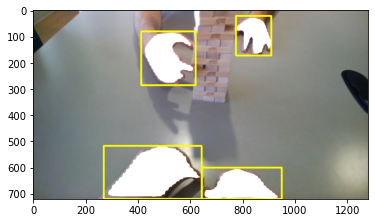

In [19]:
import cv2
i=40
model.eval()
print(i)
img, _ = dataset_test[i]
with torch.no_grad():
  prediction = model([img.to(device)])
pix = img.mul(255).permute(1, 2, 0).byte().numpy()
mask = prediction[0]['masks'].permute(1, 0, 2, 3)[0].cpu().detach().numpy()
boxes = prediction[0]['boxes'].cpu().detach().numpy()
print(boxes.shape)
print(mask.shape)
# pix= pix.reshape((pix.shape[2], pix.shape[1], pix.shape[0]))
print(pix.shape)
for j in range(boxes.shape[0]):
     cv2.rectangle(pix, (boxes[j][0], boxes[j][3]), (boxes[j][2], boxes[j][1]), (255, 255, 0), 5)
print(mask[:,700,20])
accuracy = 0.95
masks = (mask[0] > accuracy)
for j in range(1, mask.shape[0]):
    masks = masks | (mask[j] > accuracy)
print(masks.shape)
pix[(masks > accuracy)] = 255
imshow(pix)

In [20]:
prediction

[{'boxes': tensor([[645.2020, 600.3334, 950.7396, 719.6514],
          [413.2222,  81.7280, 621.4434, 286.2970],
          [775.3907,  22.7711, 910.4293, 173.3172],
          [270.2503, 517.8174, 644.1776, 719.6496]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
           

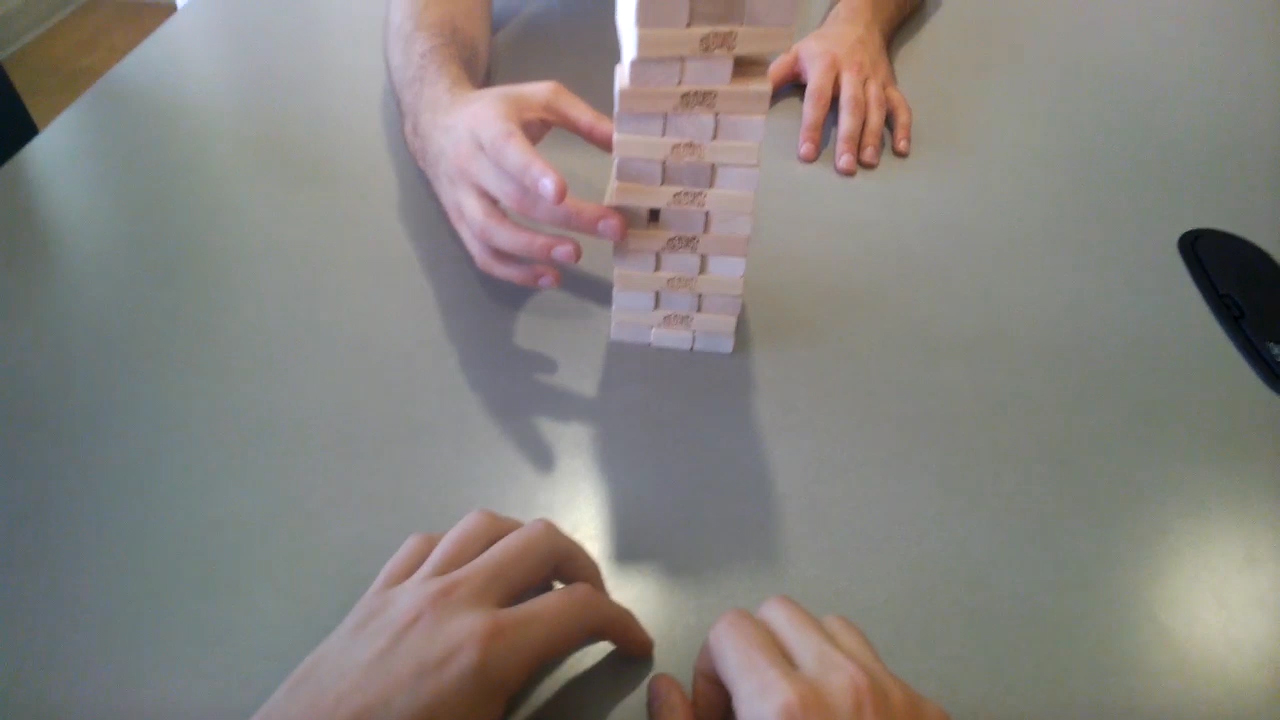

In [21]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

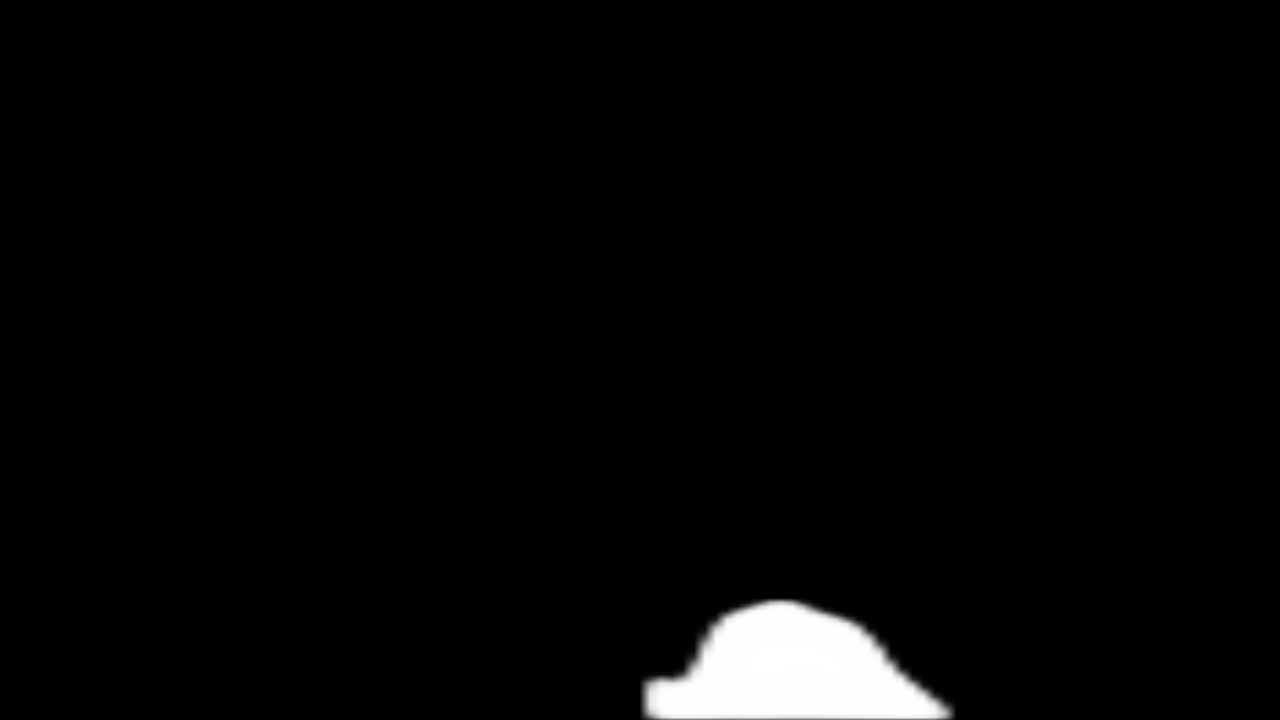

In [22]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [0]:
resume = False
if resume:
    if os.path.isfile(args.resume):
        print("=> loading checkpoint '{}'".format(args.resume))
        checkpoint = torch.load(args.resume)
        args.start_epoch = checkpoint['epoch']
        best_prec1 = checkpoint['best_prec1']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(args.resume, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(args.resume))

In [21]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return binary

ModuleNotFoundError: No module named 'google'

In [0]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image

VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""
def take_photo_2(filename='photo.jpg', quality=0.8, size=(960,720)):
  display(HTML(VIDEO_HTML % (size[0],size[1],quality)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  f = io.BytesIO(binary)
  return np.asarray(Image.open(f))

40
(4, 4)
(4, 720, 1280)
(720, 1280, 3)
[0. 0. 0. 0.]
(720, 1280)


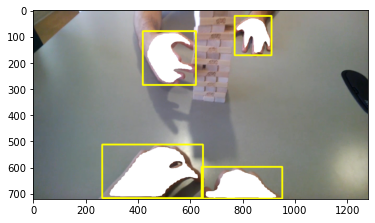

In [27]:
import cv2
i=40
model.eval()
print(i)
img, _ = dataset_test[i]
with torch.no_grad():
  prediction = model([img.to(device)])
pix = img.mul(255).permute(1, 2, 0).byte().numpy()
mask = prediction[0]['masks'].permute(1, 0, 2, 3)[0].cpu().detach().numpy()
boxes = prediction[0]['boxes'].cpu().detach().numpy()
print(boxes.shape)
print(mask.shape)
# pix= pix.reshape((pix.shape[2], pix.shape[1], pix.shape[0]))
print(pix.shape)
for j in range(boxes.shape[0]):
     cv2.rectangle(pix, (boxes[j][0], boxes[j][3]), (boxes[j][2], boxes[j][1]), (255, 255, 0), 5)
print(mask[:,700,20])
accuracy = 0.95
masks = (mask[0] > accuracy)
for j in range(1, mask.shape[0]):
    masks = masks | (mask[j] > accuracy)
print(masks.shape)
pix[(masks > accuracy)] = 255
imshow(pix)

In [23]:
import cv2
i=40
model.eval()
print(i)
# img, _ = dataset_test[i]
img = np.array(Image.open("data/1/1.jpg").convert("RGB"))
img_in = img *(1.0/255.0)
img_in = img_in.transpose(2,1,0)
with torch.no_grad():
  prediction = model([torch.as_tensor(img_in, dtype=torch.float32).to(device)])
print(prediction)
mask = prediction[0]['masks'].permute(1, 0, 3, 2)[0].cpu().detach().numpy()
boxes = prediction[0]['boxes'].cpu().detach().numpy()
print(boxes)
print(mask.shape)
# pix= pix.reshape((pix.shape[2], pix.shape[1], pix.shape[0]))
print(pix.shape)
for j in range(boxes.shape[0] - 1):
     cv2.rectangle(img, (boxes[j][1], boxes[j][0]), (boxes[j][3], boxes[j][2]), (255, 255, 0), 5)
accuracy = 0.9
masks = (mask[0] > accuracy)
for j in range(1, mask.shape[0] - 1):
    masks = masks | (mask[j] > accuracy)
print(masks.shape)
img[(masks > accuracy)] = 255
imshow(img)

40


FileNotFoundError: [Errno 2] No such file or directory: 'data/1/1.jpg'

In [137]:
from google.colab.patches import cv2_imshow
try:
  model.eval()
  photo = take_photo_2()
  # cv2_imshow(photo)
  offset_w = 160 #int((1280-960)/2)
  result = np.zeros((720,1280,3), dtype=np.float32)
  result[:,offset_w:-offset_w] = photo
  # Show the image which was just taken.
  # display(Image(filename))i=4
  # cv2_imshow(result)
  result = result *(1.0/255.0)
  result_feed = result.transpose(2,1,0)
  with torch.no_grad():
    prediction = model([torch.as_tensor(result_feed, dtype=torch.float32).to(device)])
  # pix = img.mul(255).permute(1, 2, 0).byte().numpy()
  pix = result
  mask = prediction[0]['masks'].permute(1, 0, 2, 3)[0].cpu().detach().numpy()
  boxes = prediction[0]['boxes'].cpu().detach().numpy()
  print(boxes.shape)
  print(mask.shape)
  number_of_hands = mask.shape[0]
  if(number_of_hands > 0):
    print(pix.shape)
    for j in range(boxes.shape[0]):
        cv2.rectangle(pix, (boxes[j][0], boxes[j][3]), (boxes[j][2], boxes[j][1]), (255, 255, 0), 5)
    accuracy = 0.01
    masks = (mask[0] > accuracy)
    for j in range(1, mask.shape[0]):
        masks = masks | (mask[j] > accuracy)
    print(masks.shape)
    pix[(masks > accuracy)] = 255
  imshow(pix)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

(2, 4)
(2, 1280, 720)
(720, 1280, 3)
(1280, 720)
boolean index did not match indexed array along dimension 0; dimension is 720 but corresponding boolean dimension is 1280


In [0]:
from google.colab.patches import cv2_imshow

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5500  100  5500    0     0   244k      0 --:--:-- --:--:-- --:--:--  244k


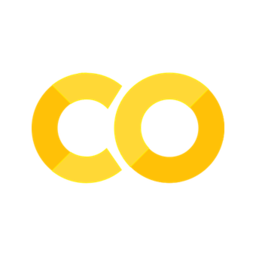

In [91]:
!curl -o logo.png https://colab.research.google.com/img/colab_favicon_256px.png
import cv2
img = cv2.imread('logo.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)